#Detección de fraude en tarjetas de crédito

* Dato en componentes principales.
* 'time' contiene los segundos entre cada transacción y la primera transacción del dataset.
* 'amountRange' es el monto aproximado de la transacción en dolares. Va de 0 a 7 en los rangos 0-1, 1-5, 5-10, 10-20, 20-50, 50-100, 100-200 and 200+.

Dado que el dato ya está preparado para realizar algoritmos de Machine Learning, no es necesario realizar ningún pre procesamiento previo.

### Imports

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Carga del dato y vista principal.

In [0]:
data_fraud = spark.read.parquet('dbfs:/databricks-datasets/credit-card-fraud/data', pathGlobFilter='*.snappy.parquet')

display(data_fraud.limit(3))


time,amountRange,label,pcaVector
52972,2,0,"Map(vectorType -> dense, length -> 28, values -> List(-0.775460885847953, 0.709595287942808, 1.61012185737375, 1.23179224889532, 0.316177505485586, 0.11441004444483, 0.410964424898908, 0.0482463120477359, 0.0160424613851936, 0.590293137181086, 1.06963744560403, -0.0970015458011077, -2.05395393083259, 0.296433513650427, -0.242125977744976, -1.10398301441835, 0.438081447824287, -0.0900982397359751, 0.972524799861282, -0.0095254201744326, -0.0313171825598146, 0.289930092783562, -0.215881463615024, 0.196378667308146, -0.267693005539635, -0.298693369594354, 0.0111946468450594, -0.0233199829808697))"
41768,6,0,"Map(vectorType -> dense, length -> 28, values -> List(0.873553941009571, -1.37751021440628, 1.07203129318284, 0.898335056199892, -1.37767734218766, 1.1341181119011, -1.04950509839334, 0.303593246528786, 0.391174678156379, 0.30645706157889, -1.74332056201875, 0.496823246907654, 0.582594013119008, -1.04298111816545, -1.09304763035534, -2.15804820205749, 0.552883029565036, 0.941659626723935, -0.878165967036597, -0.188112036138337, -0.206446493695106, -0.0208600286360115, -0.294525977933785, -0.419986418387049, 0.530461547583973, -0.0953143171911623, 0.102469833198419, 0.0613929441495575))"
40769,7,0,"Map(vectorType -> dense, length -> 28, values -> List(0.890896976094619, -0.528186780186241, -0.678653636768693, 0.168700533941972, -0.141127297738687, -1.03734480197013, 0.786720278659216, -0.463098544159764, -0.231256401727913, -0.210526809038417, -0.579607229088567, 0.320748654905059, 0.739512636179789, 0.385612185997922, 0.760072091416543, 0.0562860882084142, -0.365932329362014, -0.553207062295103, 0.225507413957292, 0.469011543311791, 0.0724908019085573, -0.283582883371654, -0.367601705300131, -0.00374237527132833, 0.548135925665169, 1.07383485281209, -0.156020333403545, 0.0292101280471998))"


### Métricas de evaluación:

Son entre 0 y 1, cuánto más cercanas a 1, mejor.

* *Área debajo de la curva Precision-Recall*: Para clases desbalanceadas. Cuántas de ambas clases fueron bien clasificadas.
* *Accuracy*: Cuántas fueron clasificadas bien (no importa la clase).
* *f1-Score*: Cuántas de la clase minoritaria fueron bien clasificadas.

**Matriz de confusión**: Cuantas muetras fueron bien y mal clasificadas.

In [0]:
def evaluator(predictions):
  # Métricas de evaluación: área debajo de la curva presicion - recall,
  # accuracy y f1-score.
  # predictions: dataframe que contiene las predicciones.
  areaUnderPR = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='label', metricName='areaUnderPR')
  evaluationAreaUnderPR = areaUnderPR.evaluate(predictions)
  print('Area Under PR curve: ' + str(evaluationAreaUnderPR))
  
  accuracy = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label',metricName="accuracy")
  evaluationAccuracy = accuracy.evaluate(predictions)
  print('Accuracy :' + str(evaluationAccuracy))
  
  f1Score = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label',metricName="f1")  
  evaluationf1Score = f1Score.evaluate(predictions)
  print('F1 Score :' + str(evaluationf1Score))
  
  
def conf_matrix(predictions, labels):
  # Grafica la matriz de confunción.
  # predictions: dataframe que contiene las predicciones.
  # labels: nombre de la columna que contiene la variable objetivo.
  conf_mat = predictions.crosstab(labels, 'prediction').orderBy(f'{labels}_prediction').toPandas()
  ax = plt.axes()
  sns.heatmap(conf_mat[['0.0', '1.0']], ax=ax, annot=True, fmt="d")
  ax.set_title('Confusion matrix')
  plt.show()

#### División entre conjunto de testeo y entrenamiento.

Se divide el dataset en dos conjuntos:
* *Entrenamiento*: los datos que se van a usar para entrenar el modelo.
* *Testeo*: los datos que se van a usar para ver el comportamiento del modelo en datos nuevos.

Este conjunto de datos está gravemente desbalanceado, el 1.4% de los datos son trasacciones fraudulentas.

In [0]:
data_fraud.groupBy('label').count()

Out[4]: DataFrame[label: int, count: bigint]

In [0]:
train, test = data_fraud.randomSplit([.8, .2], seed=42)
train.groupBy("label").count().orderBy("label").show()
test.groupBy("label").count().orderBy("label").show()

+-----+------+
|label| count|
+-----+------+
|    0|227657|
|    1|   386|
+-----+------+

+-----+-----+
|label|count|
+-----+-----+
|    0|56658|
|    1|  106|
+-----+-----+



## Entrenamiento
Se ajustará el conjunto de entrenamiento con el algoritmo *Random Forest*. Éste algoritmo está basado en  *Árboles de decisión*, entrena consecutivos árboles de manera aleatoria tomando un sub conjunto de muestras y de features, el resultado es lo que la mayoría de árboles prediga.

Métricas del conjunto de entrenamiento.
Area Under PR curve: 0.8113313720085108
Accuracy :0.9993948509710888
F1 Score :0.999372130551481
Métricas del conjunto de testeo.
Area Under PR curve: 0.8369193469146224
Accuracy :0.9994010288210838
F1 Score :0.9993766232986786


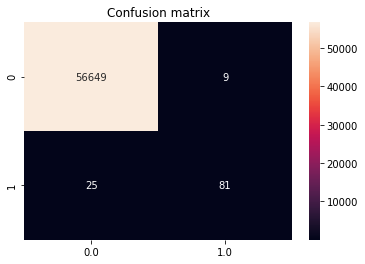

In [0]:
rf = RandomForestClassifier(featuresCol = 'pcaVector')
modelRf = rf.fit(train)
predictions_train = modelRf.transform(train)
print('Métricas del conjunto de entrenamiento.')
evaluator(predictions_train)
predictions = modelRf.transform(test)
print('Métricas del conjunto de testeo.')
evaluator(predictions)
conf_matrix(predictions, 'label')

Es un buen modelo, 81 de las 106 muestras positivas fueron bien clasificadas mientras  solo 9 de las negativas fueron mal clasificadas.

#### Undersampling

Para mejorar el comportamiento del algoritmo.

Como el dataset es altamente desbalanceado, se eliminan aleatoriamente el 90% de la clase negativa (mayoritaria, no es fraude) para que el algoritmo tienda menos a querer clasificar siempre esa clase.

In [0]:
train_under = train.sampleBy("label", fractions={0: 0.1, 1: 1.0}, seed=42)
train_under.groupBy("label").count().orderBy("label").show()

+-----+-----+
|label|count|
+-----+-----+
|    0|22734|
|    1|  386|
+-----+-----+



Area Under PR curve: 0.8923622853149514
Accuracy :0.996583044982699
F1 Score :0.9964126674441651
Area Under PR curve: 0.8200393462773624
Accuracy :0.9994538792192235
F1 Score :0.9994499669210722


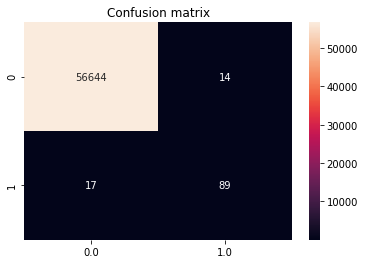

In [0]:
# Se vuelve a entrenar pero esta vez con el dataset con undersampling.
modelRf = rf.fit(train_under)
predictions_train = modelRf.transform(train_under)
evaluator(predictions_train)
predictions = modelRf.transform(test)
evaluator(predictions)
conf_matrix(predictions, 'label')

El modelo ajustado con el conjunto con undersampling clasifica bien 8 más de la clase minoritaria que el entrenado con todos los datos, mientras el costo por ello es que 5 más son mal clasificados en la clase mayoritaria. El área debajo de la curva PR del conjunto de train es mejor que en el modelo anterior, pero para el conjunto de testeo levemente menor.

### Elección del modelo

Hay muchos hiperparámetros en un algoritmo para decidir, una forma de hacerlo es entrenar consecutivos algoritmos con distintas combinaciones de hiperparámetros y evaluar cuál da mejor resultado.

En este caso, queremos que la métrica *área debajo de la curva precision - recall* sea la mejor posible, para poder elegir el modelo que mejor clasifica ambos tipos de transacciones. 

Vamos a quedarnos con el modelo donde el conjunto de entrenamiento fue undersampleado, ya que tenía mayor cantidad de muestras minoritarias bien clasificadas, que es lo más importante encontrar.

Los hiperparámetros que se eligen testear son:
* *Profundidad del lo árboles:* 5, 7 y 9,
* *Número de árboles:* 20, 40 y 50. 
Se decidió testear con ellos ya que con los valores por defecto (5 de profundidad y 20 árboles) se ve que hay muy poco de overfitting pero a su vez, podría aprender más. Se busca hacer un modelo más complejo teniendo mayor número de árboles y mayor profundidad de los mismos.

In [0]:
rf = RandomForestClassifier(featuresCol = 'pcaVector', featureSubsetStrategy = 'onethird')
# Grilla de hiperparámetros que se van a probar.
paramGrid = (ParamGridBuilder()
          .addGrid(rf.maxDepth, [5,7,9])
          .addGrid(rf.numTrees, [20,40, 50])
          .build())
# Métrica con la que se evalúa.
areaUnderPR = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='label', metricName='areaUnderPR')

# Cross Validator con 3 folds y paralelismo para que ejecute los modelos al mismo tiempo.
cv = CrossValidator(estimator= rf, evaluator=areaUnderPR, estimatorParamMaps=paramGrid,
                    numFolds=3, parallelism = 4, seed=42)

modelcv = cv.fit(train_under)

/databricks/spark/python/pyspark/ml/util.py:839: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
  warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)


In [0]:
best_params = spark.createDataFrame(list(zip(modelcv.getEstimatorParamMaps(), modelcv.avgMetrics))).orderBy('_2', ascending=False).collect()[0][0]
print(f'Los mejores parámetros son: {best_params}')

Los mejores parámetros son: {Row(doc='Number of trees to train (>= 1).', name='numTrees', parent='RandomForestClassifier_f177f984edc0', typeConverter=Row()): 40, Row(doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.', name='maxDepth', parent='RandomForestClassifier_f177f984edc0', typeConverter=Row()): 7}


Area Under PR curve: 0.8678149606735387
Accuracy :0.9994538792192235
F1 Score :0.9994525875038542


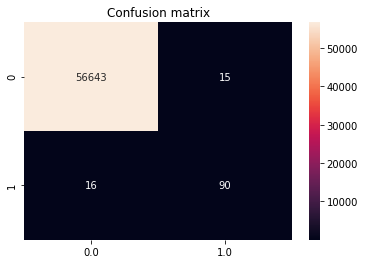

In [0]:
predictionsCv = modelcv.transform(test)
evaluator(predictionsCv)
conf_matrix(predictionsCv, 'label')

# Conclusiones
Se entrenó un algoritmo de Random Forest con el conjunto de entrenamiento, dando buenos resultados en el conjunto de test. Para mejorar un poco la performance del algoritmo se le aplicó la técnica de undersampling para tener un conjunto de entrenamiento más balanceado. Los resultados de hacer este procedimiento fueron buenos por lo que se recurrió a la elección de hiperparámetros por el método de cross validation.

Luego de la elección de hiperparámetros, los mejores fueron que la profundidad máxima de los árboles sea de 7 y la cantidad 40. Hay 90 bien clasificados de la clase minoritaria y 15 mal de la clase mayoritaria. Se concluye que el algoritmo es capaz de detectar automaticamente transacciones con fraude en tarjetas de crédito.